In [153]:
# Install required packages if not already installed
import subprocess
import sys
import importlib.util

def check_and_install(pip_name, import_name=None):
    """Check if package is installed, install if not."""
    if import_name is None:
        import_name = pip_name
    
    # First, try to find the spec without importing (safer)
    spec = importlib.util.find_spec(import_name)
    if spec is not None:
        # Package exists, try to import it to verify it works
        try:
            __import__(import_name)
            print(f"✓ {pip_name} is already installed")
            return False
        except ImportError:
            # Module not found - needs installation
            pass
        except (AttributeError, RuntimeError) as e:
            # For packages like pandas that may have circular imports during check,
            # if the spec exists and we get AttributeError, it means the package is installed
            # but there's an internal import issue (which is fine, it will work when properly imported)
            print(f"✓ {pip_name} is already installed (detected despite import check warning)")
            return False
    
    # Package not found, install it
    print(f"Installing {pip_name}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
    print(f"✓ {pip_name} installed successfully")
    return True

# Package mapping: (pip package name, import name)
packages = [
    ('beautifulsoup4', 'bs4'),
    ('requests', 'requests'),
    ('pandas', 'pandas'),
    ('numpy', 'numpy'),
    ('wordcloud', 'wordcloud'),
    ('matplotlib', 'matplotlib'),
    ('lxml', 'lxml')
]

newly_installed = []
for pip_name, import_name in packages:
    if check_and_install(pip_name, import_name):
        newly_installed.append(pip_name)

if newly_installed:
    print(f"\n⚠️  Newly installed packages: {', '.join(newly_installed)}")
    print("⚠️  You may need to restart the kernel for changes to take effect.")
else:
    print("\n✓ All packages are already installed!")


✓ beautifulsoup4 is already installed
✓ requests is already installed
✓ pandas is already installed
✓ numpy is already installed
✓ wordcloud is already installed
✓ matplotlib is already installed
✓ lxml is already installed

✓ All packages are already installed!


In [154]:
# Import required libraries
# Note: If you get a pandas import error, restart the kernel (Kernel -> Restart Kernel)

# Clear any cached pandas modules if they exist
import sys
if 'pandas' in sys.modules:
    del sys.modules['pandas']
if 'pandas._testing' in sys.modules:
    del sys.modules['pandas._testing']

from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import os

# Create directories if they don't exist
os.makedirs('data', exist_ok=True)
os.makedirs('visualizations', exist_ok=True)


In [155]:
# Fetch Spanish number-one singles data from Wikipedia for years 2000-2025
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3'}

years = range(2000, 2026)  # 2000 to 2025
all_years_data = []

print(f"Fetching data for years {min(years)}-{max(years)}...")
print("=" * 60)

for year in years:
    try:
        url = f'https://en.wikipedia.org/wiki/List_of_number-one_singles_of_{year}_(Spain)'
        print(f"Fetching {year}...", end=' ')
        html = requests.get(url, cookies={'sessionid': '123..'}, headers=headers, timeout=10).text
        soup = BeautifulSoup(html, 'lxml')
        
        # Find the table
        my_table = soup.find('table', {'class': 'wikitable sortable'})
        if my_table is None:
            my_table = soup.find('table', {'class': 'wikitable'})
        
        if my_table:
            all_years_data.append((year, my_table))
            print(f"✓ Found table")
        else:
            print(f"✗ No table found")
    except Exception as e:
        print(f"✗ Error: {str(e)[:50]}")

print("=" * 60)
print(f"Successfully fetched data for {len(all_years_data)} years")


Fetching data for years 2000-2025...
Fetching 2000... ✓ Found table
Fetching 2001... ✓ Found table
Fetching 2002... ✓ Found table
Fetching 2003... ✗ No table found
Fetching 2004... ✓ Found table
Fetching 2005... ✓ Found table
Fetching 2006... ✓ Found table
Fetching 2007... ✓ Found table
Fetching 2008... ✓ Found table
Fetching 2009... ✓ Found table
Fetching 2010... ✓ Found table
Fetching 2011... ✓ Found table
Fetching 2012... ✓ Found table
Fetching 2013... ✓ Found table
Fetching 2014... ✓ Found table
Fetching 2015... ✓ Found table
Fetching 2016... ✓ Found table
Fetching 2017... ✓ Found table
Fetching 2018... ✓ Found table
Fetching 2019... ✓ Found table
Fetching 2020... ✓ Found table
Fetching 2021... ✓ Found table
Fetching 2022... ✓ Found table
Fetching 2023... ✓ Found table
Fetching 2024... ✓ Found table
Fetching 2025... ✓ Found table
Successfully fetched data for 25 years


In [156]:
# Parse all tables and combine the data
all_chart_data = []

def parse_table(my_table, year):
    """Parse a single year's table and return chart data."""
    # Get header row to understand table structure
    header_row = my_table.find('tr')
    headers = [th.get_text(strip=True).lower() for th in header_row.find_all(['th', 'td'])]
    
    # Detect table structure
    has_streaming_section = any('streaming' in h or 'top streaming' in h for h in headers)
    has_airplay_section = any('airplay' in h or 'most airplay' in h for h in headers)
    
    rows = my_table.find_all('tr')[1:]  # Skip header row
    chart_data = []
    
    # Track rowspans for both sections
    streaming_artist = None
    streaming_artist_span = 0
    streaming_song = None
    streaming_song_span = 0
    
    airplay_artist = None
    airplay_artist_span = 0
    airplay_song = None
    airplay_song_span = 0
    
    # Check if table has Week column by looking at header and first data rows
    has_week_column = False
    # Check header first
    if header_row:
        header_text = header_row.get_text(strip=True).lower()
        if 'week' in header_text:
            has_week_column = True
    
    # Also check first data row to confirm
    if rows and not has_week_column:
        first_row_cells = rows[0].find_all(['td', 'th'])
        if first_row_cells:
            first_cell = first_row_cells[0].get_text(strip=True)
            # Check if first cell is a week number (1-53) and second cell looks like a date
            if first_cell.isdigit() and len(first_cell) <= 3:
                if len(first_row_cells) > 1:
                    second_cell = first_row_cells[1].get_text(strip=True)
                    # If second cell looks like a date (contains month names or date patterns), first is likely Week
                    month_names = ['january', 'february', 'march', 'april', 'may', 'june', 
                                  'july', 'august', 'september', 'october', 'november', 'december',
                                  'enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio',
                                  'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
                    if any(month in second_cell.lower() for month in month_names):
                        has_week_column = True
    
    # For simpler tables (pre-2010), we might only have: Issue date, Artist, Song
    # For complex tables (2010+), we have: Week, Issue date, Streaming Artist, Streaming Song, Ref, Airplay Artist, Airplay Song, Ref
    is_simple_structure = not (has_streaming_section and has_airplay_section)
    
    for row in rows:
        cells = row.find_all(['td', 'th'])
        if len(cells) < 2:  # Skip empty rows
            continue
        
        # Skip header rows (rows that contain typical header text)
        first_cell_text = cells[0].get_text(strip=True).lower() if cells else ""
        header_keywords = ['week', 'issue date', 'issue date', 'artist', 'song', 'fecha', 'artista', 'canción']
        if any(keyword in first_cell_text for keyword in header_keywords) and len(first_cell_text) < 20:
            continue  # Skip header rows
        
        week_data = {}
        week_data['Year'] = year  # Add year to each record
        
        col_idx = 0
        
        # Handle Week column (if present) - column 0
        # Be flexible: if has_week_column is True but first cell looks like a date, treat as no week column
        if has_week_column:
            if len(cells) > col_idx:
                week_text = cells[col_idx].get_text(strip=True)
                # Check if it's actually a date (contains month names)
                month_names = ['january', 'february', 'march', 'april', 'may', 'june', 
                              'july', 'august', 'september', 'october', 'november', 'december',
                              'enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio',
                              'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
                if week_text and any(month in week_text.lower() for month in month_names):
                    # This is actually a date, not a week - treat as no week column
                    week_data['Week'] = None
                    # Don't increment col_idx, we'll use this as Issue_date
                elif week_text and week_text.isdigit() and 1 <= int(week_text) <= 53:
                    # Valid week number
                    week_data['Week'] = int(week_text)
                    col_idx += 1
                else:
                    # Doesn't look like week or date, skip this row
                    continue
            else:
                week_data['Week'] = None
        else:
            # No week column, set Week to None
            week_data['Week'] = None
        
        # Issue date - column 1 if Week exists, otherwise column 0
        if 'Issue_date' not in week_data:  # Only read if we didn't already set it above
            if len(cells) > col_idx:
                issue_date = cells[col_idx].get_text(strip=True)
                # Skip if it looks like a reference ([1], [2], etc.)
                if issue_date and not issue_date.startswith('['):
                    week_data['Issue_date'] = issue_date
                elif not issue_date:
                    continue  # Skip if no issue date
                else:
                    # It's a reference, skip this row
                    continue
                col_idx += 1
            else:
                continue  # Skip if no issue date column
        
        # Determine column structure based on table format
        if is_simple_structure:
            # Simple structure: Issue date, Artist, Song (or similar)
            # For these years, we'll treat all data as "Streaming" since there's no distinction
            if col_idx < len(cells):
                # This should be Artist (or Song, depending on structure)
                artist_cell = cells[col_idx]
                try:
                    rowspan_val = artist_cell.attrs.get('rowspan')
                    if rowspan_val:
                        streaming_artist = artist_cell.get_text(strip=True)
                        streaming_artist_span = int(rowspan_val) - 1
                    elif streaming_artist_span > 0:
                        streaming_artist_span -= 1
                    else:
                        streaming_artist = artist_cell.get_text(strip=True)
                        streaming_artist_span = 0
                except (KeyError, AttributeError):
                    streaming_artist = artist_cell.get_text(strip=True)
                    streaming_artist_span = 0
                col_idx += 1
            
            if col_idx < len(cells):
                # This should be Song
                song_cell = cells[col_idx]
                try:
                    rowspan_val = song_cell.attrs.get('rowspan')
                    if rowspan_val:
                        streaming_song = song_cell.get_text(strip=True)
                        streaming_song_span = int(rowspan_val) - 1
                    elif streaming_song_span > 0:
                        streaming_song_span -= 1
                    else:
                        streaming_song = song_cell.get_text(strip=True)
                        streaming_song_span = 0
                except (KeyError, AttributeError):
                    streaming_song = song_cell.get_text(strip=True)
                    streaming_song_span = 0
                col_idx += 1
            
            # For simple structure, set airplay to empty
            week_data['Streaming_Artist'] = streaming_artist
            week_data['Streaming_Song'] = streaming_song
            week_data['Airplay_Artist'] = None
            week_data['Airplay_Song'] = None
            
        else:
            # Complex structure: Streaming section (Artist, Song, Ref), then Airplay section (Artist, Song, Ref)
            # Top Streaming section starts after Week (if present) and Issue date
            # Streaming Artist
            if col_idx < len(cells):
                cell = cells[col_idx]
                try:
                    rowspan_val = cell.attrs.get('rowspan')
                    if rowspan_val:
                        streaming_artist = cell.get_text(strip=True)
                        streaming_artist_span = int(rowspan_val) - 1  # -1 because current row counts
                    elif streaming_artist_span > 0:
                        streaming_artist_span -= 1
                        # Use previous value, don't read new text
                    else:
                        # No active rowspan, read new text from this cell
                        streaming_artist = cell.get_text(strip=True)
                        streaming_artist_span = 0
                except (KeyError, AttributeError):
                    # No rowspan attribute, read new text
                    streaming_artist = cell.get_text(strip=True)
                    streaming_artist_span = 0
                week_data['Streaming_Artist'] = streaming_artist
                col_idx += 1
            
            # Streaming Song
            if col_idx < len(cells):
                cell = cells[col_idx]
                try:
                    rowspan_val = cell.attrs.get('rowspan')
                    if rowspan_val:
                        streaming_song = cell.get_text(strip=True)
                        streaming_song_span = int(rowspan_val) - 1  # -1 because current row counts
                    elif streaming_song_span > 0:
                        streaming_song_span -= 1
                        # Use previous value, don't read new text
                    else:
                        # No active rowspan, read new text from this cell
                        streaming_song = cell.get_text(strip=True)
                        streaming_song_span = 0
                except (KeyError, AttributeError):
                    # No rowspan attribute, read new text
                    streaming_song = cell.get_text(strip=True)
                    streaming_song_span = 0
                week_data['Streaming_Song'] = streaming_song
                col_idx += 1
            
            # Streaming Ref (skip reference column - look for [1], [2] patterns)
            if col_idx < len(cells):
                ref_cell = cells[col_idx].get_text(strip=True)
                # Only skip if it looks like a reference, otherwise it might be a data column
                if ref_cell.startswith('[') and ref_cell.endswith(']'):
                    col_idx += 1  # Skip reference column
                # If it doesn't look like a reference, it might be the next data column, so don't skip
            
            # Most Airplay section (columns 5-7: Artist, Song, Ref)
            # Airplay Artist
            if col_idx < len(cells):
                cell = cells[col_idx]
                try:
                    rowspan_val = cell.attrs.get('rowspan')
                    if rowspan_val:
                        airplay_artist = cell.get_text(strip=True)
                        airplay_artist_span = int(rowspan_val) - 1  # -1 because current row counts
                    elif airplay_artist_span > 0:
                        airplay_artist_span -= 1
                        # Use previous value, don't read new text
                    else:
                        # No active rowspan, read new text from this cell
                        airplay_artist = cell.get_text(strip=True)
                        airplay_artist_span = 0
                except (KeyError, AttributeError):
                    # No rowspan attribute, read new text
                    airplay_artist = cell.get_text(strip=True)
                    airplay_artist_span = 0
                week_data['Airplay_Artist'] = airplay_artist
                col_idx += 1
            
            # Airplay Song
            if col_idx < len(cells):
                cell = cells[col_idx]
                try:
                    rowspan_val = cell.attrs.get('rowspan')
                    if rowspan_val:
                        airplay_song = cell.get_text(strip=True)
                        airplay_song_span = int(rowspan_val) - 1  # -1 because current row counts
                    elif airplay_song_span > 0:
                        airplay_song_span -= 1
                        # Use previous value, don't read new text
                    else:
                        # No active rowspan, read new text from this cell
                        airplay_song = cell.get_text(strip=True)
                        airplay_song_span = 0
                except (KeyError, AttributeError):
                    # No rowspan attribute, read new text
                    airplay_song = cell.get_text(strip=True)
                    airplay_song_span = 0
                week_data['Airplay_Song'] = airplay_song
            
            # Airplay Ref (skip reference column if present)
            # Note: We don't need to process this, just skip it if it exists
        
        # Only add if we have at least an Issue date
        if week_data.get('Issue_date'):
            chart_data.append(week_data)
    
    return chart_data

# Parse all years
print("Parsing tables...")
for year, table in all_years_data:
    year_data = parse_table(table, year)
    all_chart_data.extend(year_data)
    print(f"  {year}: {len(year_data)} weeks extracted")

print(f"\nTotal: {len(all_chart_data)} weeks of data across all years")


Parsing tables...
  2000: 24 weeks extracted
  2001: 25 weeks extracted
  2002: 27 weeks extracted
  2004: 29 weeks extracted
  2005: 36 weeks extracted
  2006: 33 weeks extracted
  2007: 30 weeks extracted
  2008: 16 weeks extracted
  2009: 12 weeks extracted
  2010: 52 weeks extracted
  2011: 52 weeks extracted
  2012: 52 weeks extracted
  2013: 52 weeks extracted
  2014: 52 weeks extracted
  2015: 53 weeks extracted
  2016: 52 weeks extracted
  2017: 52 weeks extracted
  2018: 52 weeks extracted
  2019: 52 weeks extracted
  2020: 53 weeks extracted
  2021: 53 weeks extracted
  2022: 52 weeks extracted
  2023: 53 weeks extracted
  2024: 53 weeks extracted
  2025: 43 weeks extracted

Total: 1060 weeks of data across all years


In [157]:
# Convert to DataFrame and clean the data
df = pd.DataFrame(all_chart_data)

# Clean song titles - remove quotation marks and clean text
def clean_title(title):
    if pd.isna(title) or not title:
        return ''
    title = str(title)
    # Remove quotation marks (including triple quotes)
    title = title.replace('"', '').replace("'", '').replace('"""', '')
    # Remove brackets and parentheses content (references and annotations)
    title = re.sub(r'\[.*?\]', '', title)
    title = re.sub(r'\(.*?\)', '', title)
    title = title.strip()
    return title

df['Streaming_Song_Clean'] = df['Streaming_Song'].apply(clean_title)
df['Airplay_Song_Clean'] = df['Airplay_Song'].apply(clean_title)

# Clean artist names - similar to song titles but preserve "featuring" relationships
def clean_artist(artist):
    if pd.isna(artist) or not artist:
        return ''
    artist = str(artist)
    # Remove quotation marks
    artist = artist.replace('"', '').replace("'", '').replace('"""', '')
    # Remove brackets (references)
    artist = re.sub(r'\[.*?\]', '', artist)
    # Keep parentheses for "feat." or "featuring" info, but clean spacing
    artist = re.sub(r'\s+', ' ', artist)  # Normalize whitespace
    artist = artist.strip()
    return artist

df['Streaming_Artist_Clean'] = df['Streaming_Artist'].apply(clean_artist)
df['Airplay_Artist_Clean'] = df['Airplay_Artist'].apply(clean_artist)

# Remove rows where both songs are empty
df = df[~(df['Streaming_Song_Clean'].isna() & df['Airplay_Song_Clean'].isna())]

print(f"Processed {len(df)} weeks of chart data across {df['Year'].nunique()} years")
print(f"\nYears covered: {sorted(df['Year'].unique())}")
print(f"\nData summary by year:")
print(df.groupby('Year').size().sort_index())
print("\nFirst few rows:")
print(df[['Year', 'Week', 'Issue_date', 'Streaming_Song_Clean', 'Airplay_Song_Clean']].head(10))


Processed 1060 weeks of chart data across 25 years

Years covered: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

Data summary by year:
Year
2000    24
2001    25
2002    27
2004    29
2005    36
2006    33
2007    30
2008    16
2009    12
2010    52
2011    52
2012    52
2013    52
2014    52
2015    53
2016    52
2017    52
2018    52
2019    52
2020    53
2021    53
2022    52
2023    53
2024    53
2025    43
dtype: int64

First few rows:
   Year  Week   Issue_date Streaming_Song_Clean Airplay_Song_Clean
0  2000   NaN    1 January     Enrique Iglesias                   
1  2000   NaN   29 January     Enrique Iglesias                  

In [158]:
# DEBUG: Create a CSV with only the first week from each year to verify column mapping
debug_df = df.groupby('Year').first().reset_index()

# Show all columns for debugging
debug_csv_path = 'data/spain_top1_debug_first_week_per_year.csv'
debug_df.to_csv(debug_csv_path, index=False)

print("=" * 80)
print("DEBUG: First week from each year (to verify column mapping)")
print("=" * 80)
print(f"\nSaved to: {debug_csv_path}\n")

# Display with all relevant columns
display_cols = ['Year', 'Week', 'Issue_date', 
                'Streaming_Artist', 'Streaming_Song', 
                'Airplay_Artist', 'Airplay_Song',
                'Streaming_Song_Clean', 'Airplay_Song_Clean']

print(debug_df[display_cols].to_string(index=False))
print("\n" + "=" * 80)
print("Check if Streaming_Song contains song names (not artist names)")
print("Check if Airplay_Song contains song names (not artist names)")
print("=" * 80)


DEBUG: First week from each year (to verify column mapping)

Saved to: data/spain_top1_debug_first_week_per_year.csv

 Year  Week  Issue_date                Streaming_Artist          Streaming_Song                    Airplay_Artist               Airplay_Song  Streaming_Song_Clean       Airplay_Song_Clean
 2000   NaN   1 January                   Rhythm Divine        Enrique Iglesias                              None                       None      Enrique Iglesias                         
 2001   NaN   1 January                       No cambié                  Tamara                              None                       None                Tamara                         
 2002   NaN   7 January                 Abre Tu Sonrisa               Sugarless                              None                       None             Sugarless                         
 2004   NaN   January 4     "Motivos de un sentimiento"          Joaquín Sabina                              None                 

In [159]:
# Save data to CSV
csv_path = f'data/spain_top1_{df["Year"].min()}_{df["Year"].max()}.csv'
df.to_csv(csv_path, index=False)
print(f"Data saved to {csv_path}")
print(f"Total records: {len(df)}")
print(f"Years: {df['Year'].min()} - {df['Year'].max()}")


Data saved to data/spain_top1_2000_2025.csv
Total records: 1060
Years: 2000 - 2025


In [160]:
# Prepare text for word cloud - combine both Streaming and Airplay songs
# Each song appears once per week it was #1, giving natural weighting
song_titles_text = []

# Add streaming songs
for title in df['Streaming_Song_Clean']:
    if title and title.strip():
        song_titles_text.append(str(title).lower())

# Add airplay songs
for title in df['Airplay_Song_Clean']:
    if title and title.strip():
        song_titles_text.append(str(title).lower())

fulltext = ' '.join(song_titles_text)
print(f"Total words in text: {len(fulltext.split())}")
print(f"Unique songs (streaming): {df['Streaming_Song_Clean'].nunique()}")
print(f"Unique songs (airplay): {df['Airplay_Song_Clean'].nunique()}")
print(f"Total weeks of data: {len(df)}")
print(f"Years covered: {df['Year'].min()}-{df['Year'].max()}")
print(f"\nSample of songs: {song_titles_text[:15]}")


Total words in text: 2682
Unique songs (streaming): 390
Unique songs (airplay): 71
Total weeks of data: 1060
Years covered: 2000-2025

Sample of songs: ['enrique iglesias', 'enrique iglesias', 'enrique iglesias', 'enrique iglesias', 'aqua', 'oasis', 'bloodhound gang', 'madonna', 'mónica naranjo', 'mónica naranjo', 'mónica naranjo', 'gloria estefan', 'gloria estefan', 'britney spears', 'tony sweat']


In [161]:
# Prepare text for word cloud - combine both Streaming and Airplay songs
# Each song appears once per week it was #1, giving natural weighting
song_titles_text = []

# Add streaming songs
for title in df['Streaming_Song_Clean']:
    if title and title.strip():
        song_titles_text.append(str(title).lower())

# Add airplay songs
for title in df['Airplay_Song_Clean']:
    if title and title.strip():
        song_titles_text.append(str(title).lower())

fulltext = ' '.join(song_titles_text)
print(f"Total words in text: {len(fulltext.split())}")
print(f"Unique songs (streaming): {df['Streaming_Song_Clean'].nunique()}")
print(f"Unique songs (airplay): {df['Airplay_Song_Clean'].nunique()}")
print(f"Total weeks of data: {len(df)}")
print(f"Years covered: {df['Year'].min()}-{df['Year'].max()}")
print(f"\nSample of songs: {song_titles_text[:15]}")


Total words in text: 2682
Unique songs (streaming): 390
Unique songs (airplay): 71
Total weeks of data: 1060
Years covered: 2000-2025

Sample of songs: ['enrique iglesias', 'enrique iglesias', 'enrique iglesias', 'enrique iglesias', 'aqua', 'oasis', 'bloodhound gang', 'madonna', 'mónica naranjo', 'mónica naranjo', 'mónica naranjo', 'gloria estefan', 'gloria estefan', 'britney spears', 'tony sweat']


In [162]:
# Create word cloud from song titles
stopwords = set(STOPWORDS)
# Add common words in Spanish and English that might not be interesting
stopwords.update(['featuring', 'feat', 'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
                 'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 'de', 'del', 'en', 'con', 'por', 'para', 'que', 'y', 'o'])

wordcloud = WordCloud(
    stopwords=stopwords,
    width=1920,
    height=1080,
    max_words=200,
    background_color='white',
    max_font_size=300,
    colormap='viridis',
    collocations=False,
    relative_scaling=0.5
).generate(fulltext)

print("Word cloud generated successfully!")


Word cloud generated successfully!


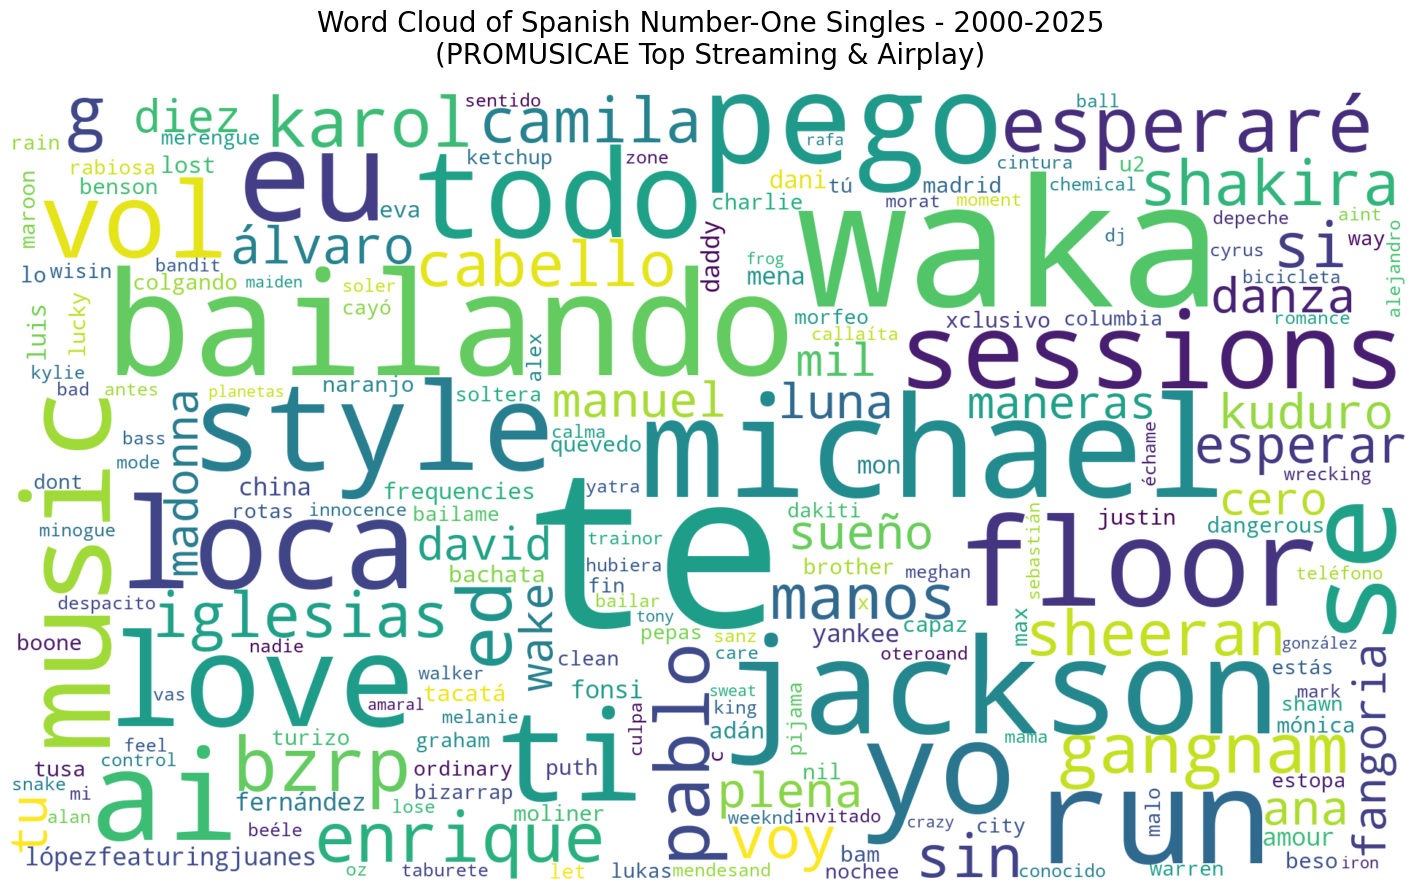

In [163]:
# Display the word cloud
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f'Word Cloud of Spanish Number-One Singles - {df["Year"].min()}-{df["Year"].max()}\n(PROMUSICAE Top Streaming & Airplay)', fontsize=20, pad=20)
plt.tight_layout()
plt.show()


In [164]:
# Save the word cloud
output_path = f'visualizations/spain_top1_{df["Year"].min()}_{df["Year"].max()}_wordcloud.png'
wordcloud.to_file(output_path)
print(f"Word cloud saved to {output_path}")


Word cloud saved to visualizations/spain_top1_2000_2025_wordcloud.png


In [165]:
# Prepare text for artist word cloud - combine both Streaming and Airplay artists
# Each artist appears once per week they were #1, giving natural weighting
artist_names_text = []

# Add streaming artists
for artist in df['Streaming_Artist_Clean']:
    if artist and artist.strip():
        # Split multi-artist entries (e.g., "Artist1 feat. Artist2" or "Artist1 & Artist2")
        # This helps show individual artist names in the word cloud
        artist_lower = str(artist).lower()
        # Split on common separators
        artists = re.split(r'\s+(?:feat\.?|featuring|&|and|y|,)\s+', artist_lower)
        for a in artists:
            a = a.strip()
            if a:
                artist_names_text.append(a)

# Add airplay artists
for artist in df['Airplay_Artist_Clean']:
    if artist and artist.strip():
        artist_lower = str(artist).lower()
        artists = re.split(r'\s+(?:feat\.?|featuring|&|and|y|,)\s+', artist_lower)
        for a in artists:
            a = a.strip()
            if a:
                artist_names_text.append(a)

fulltext_artists = ' '.join(artist_names_text)
print(f"Total artist words in text: {len(fulltext_artists.split())}")
print(f"Unique artists (streaming): {df['Streaming_Artist_Clean'].nunique()}")
print(f"Unique artists (airplay): {df['Airplay_Artist_Clean'].nunique()}")
print(f"Years covered: {df['Year'].min()}-{df['Year'].max()}")
print(f"\nSample of artists: {artist_names_text[:20]}")


Total artist words in text: 3756
Unique artists (streaming): 352
Unique artists (airplay): 154
Years covered: 2000-2025

Sample of artists: ['rhythm divine', 'rhythm divine', 'rhythm divine', 'rhythm divine', 'cartoon heroes', 'go let it out', 'the bad touch', 'american pie', 'sobreviviré', 'sobreviviré', 'sobreviviré', 'no me dejes de querer', 'no me dejes de querer', 'oops!... i did it again', 'sex machine (get up i feel like being like a sex machine)', 'sex machine (get up i feel like being like a sex machine)', 'sex machine (get up i feel like being like a sex machine)', 'if you leave me now', 'boom boom', 'ya no quiero tu querer']


In [166]:
# Create word cloud from artist names
stopwords_artists = set(STOPWORDS)
# Add common words in Spanish and English that might not be interesting for artists
stopwords_artists.update(['featuring', 'feat', 'feat.', 'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
                           'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 'de', 'del', 'en', 'con', 'por', 'para', 'que', 'y', 'o',
                           'crew', 'band', 'group'])

wordcloud_artists = WordCloud(
    stopwords=stopwords_artists,
    width=1920,
    height=1080,
    max_words=200,
    background_color='white',
    max_font_size=300,
    colormap='plasma',  # Different colormap to distinguish from song word cloud
    collocations=False,
    relative_scaling=0.5
).generate(fulltext_artists)

print("Artist word cloud generated successfully!")


Artist word cloud generated successfully!


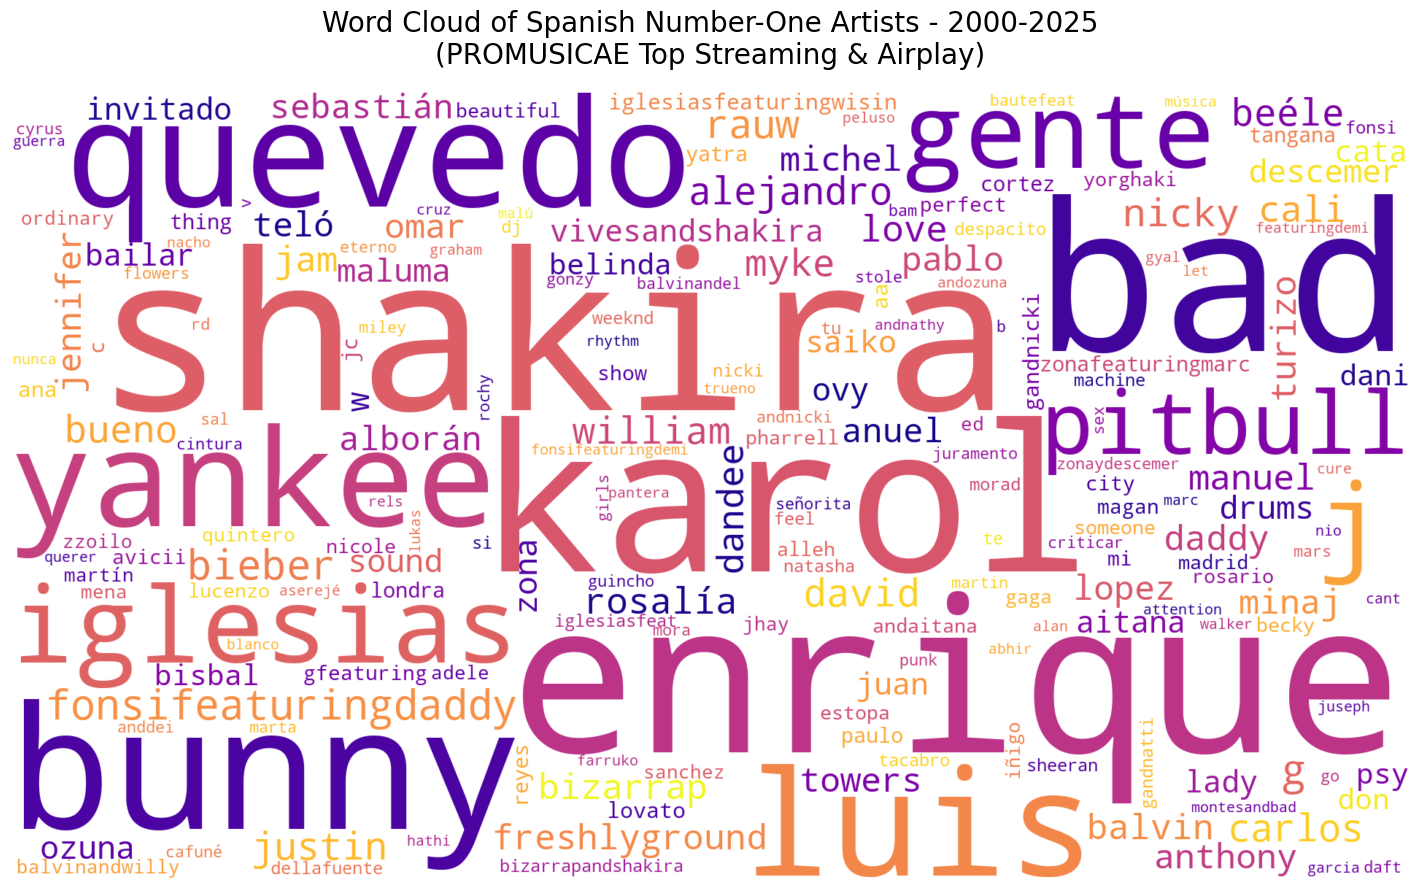

In [167]:
# Display the artist word cloud
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud_artists, interpolation='bilinear')
plt.axis("off")
plt.title(f'Word Cloud of Spanish Number-One Artists - {df["Year"].min()}-{df["Year"].max()}\n(PROMUSICAE Top Streaming & Airplay)', fontsize=20, pad=20)
plt.tight_layout()
plt.show()


In [168]:
# Save the artist word cloud
output_path_artists = f'visualizations/spain_top1_{df["Year"].min()}_{df["Year"].max()}_artists_wordcloud.png'
wordcloud_artists.to_file(output_path_artists)
print(f"Artist word cloud saved to {output_path_artists}")


Artist word cloud saved to visualizations/spain_top1_2000_2025_artists_wordcloud.png
